In [3]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')


In [4]:
# Read data
file = "energydata_complete.csv"
df = pd.read_csv(file, parse_dates=['date'])

# Lowercase the column names
df.columns = [x.lower() for x in df.columns]

# Set datetime index due to time series analysis 
df = df.set_index('date')
df.head()

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,t5,rh_5,t6,rh_6,t7,rh_7,t8,rh_8,t9,rh_9,t_out,press_mm_hg,rh_out,windspeed,visibility,tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In this data set there are informations about the energy consumption of a house's appliances, temperature and humidity of house's rooms. In addition, there are data(temperature,pressure,humidity, visibility,windspeed and Tdewpoint) of weather conditions in the given area. The data set is at 10 min for about 4.5 months.

Our goal is to make appliances' energy load forecasting.

# 1. Feature Engineering
Check for outliers: We will consider as outliers the 0,1% top values of appliances' load because it is fact that recordings of power load higher than 800Wh from a house appliance are not logical. These may be false recordings caused by an instant fault on the recording devices. Additionally, in this data set there are not any NA values.

The number of the 0,1% top values of appliances' load is 19 and they have power load higher than 790 Wh.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


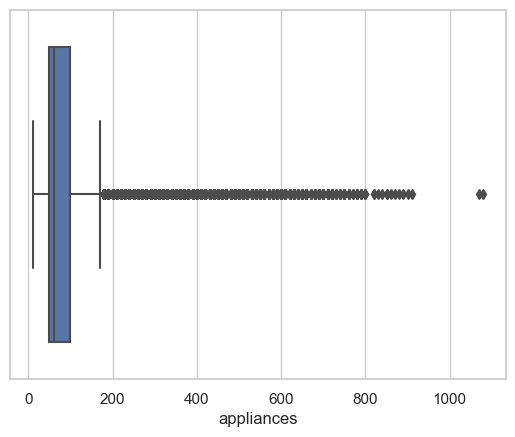

In [5]:
# Find outliers
sorted_appliances = df.sort_values('appliances',ascending=False)
print("The number of the 0,1% top values of appliances' load is",len(sorted_appliances)//1000,"and they have power load higher than",
      sorted_appliances.appliances[len(sorted_appliances)//1000], "Wh.")

# boxplot appliance
sns.set(style='whitegrid')
ax = sns.boxplot(sorted_appliances.appliances)

In [6]:
# Outliers removal
df = df.dropna()
df = df.drop(df[(df.appliances > 790) | (df.appliances <0)].index)

The idea is that appliances' load is hour, day, week, month dependent. It is logical assumption that in night hours the load is low or at weekends the energy consumption is higher than the weekdays because more people are at home.

Additionaly, it is expected a correlation between temperature/humidity and energy load. For instance, when someone cooks(higher consumption) probably the temperature in the kichen raises.

Moreover, we can use qualitative predictors to indicate if a mesured load is lower or higher in comparison to the average energy load a given time interval.

I will append several columns as new features to the original data, based on the above-mentioned assumptions and then i will find out which of them explain better appliances consumption.

In [7]:
# Append more columns to the dataframe based on datetime
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['week'] = df.index.week
df.head()

C:\Users\simon\AppData\Local\Temp\ipykernel_8872\2099930150.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week


,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,t5,rh_5,t6,rh_6,t7,rh_7,t8,rh_8,t9,rh_9,t_out,press_mm_hg,rh_out,windspeed,visibility,tdewpoint,rv1,rv2,month,weekday,hour,week
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,1,0,17,2
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,1,0,17,2
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,1,0,17,2
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,1,0,17,2
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,1,0,17,2


(array([13509.,  4018.,   600.,   607.,   415.,   246.,   120.,   106.,
           61.,    36.]),
 array([ 10.,  88., 166., 244., 322., 400., 478., 556., 634., 712., 790.]),
 <BarContainer object of 10 artists>)

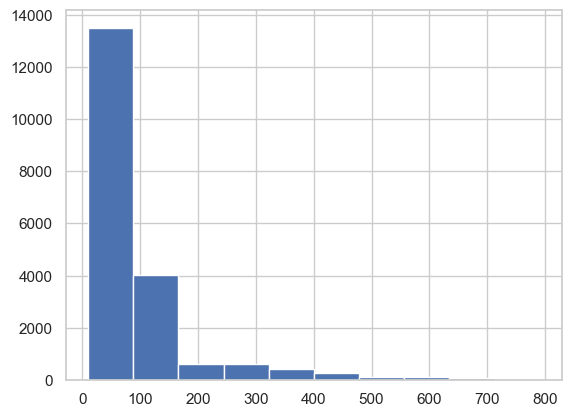

In [8]:
plt.hist(df.appliances) #频次直方图

(array([   9.,  343.,  723., 6387., 6047., 3561.,  818.,  846.,  732.,
         252.]),
 array([2.30258509, 2.73952988, 3.17647466, 3.61341945, 4.05036423,
        4.48730902, 4.9242538 , 5.36119859, 5.79814337, 6.23508816,
        6.67203295]),
 <BarContainer object of 10 artists>)

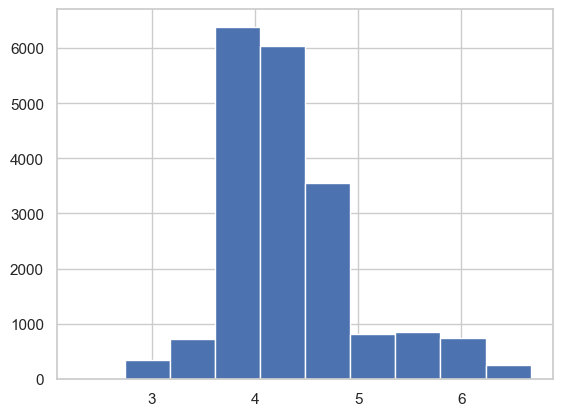

In [9]:
# 数据右偏，在做线性回归的时候假设数据正态分布，一般用log函数校正
df['log_appliances'] = np.log(df.appliances)
plt.hist(df.log_appliances)

In [31]:
# Average house temperature and humidity
df['house_temp'] =(df.t1+df.t2+df.t3+df.t4+df.t5+df.t7+df.t8+df.t9)/8
df['house_hum'] =(df.rh_1+df.rh_2+df.rh_3+df.rh_4+df.rh_5+df.rh_7+df.rh_8+df.rh_9)/8

# Products of several features to remove additive assumption(An Introducton to Statistical learning p. 87,88)
df['hour*light']= df.hour * df.lights
df['t3rh3'] = df.t3 * df.rh_3
df['t2rh2'] = df.t2 * df.rh_2
df['t1rh1'] = df.t2 * df.rh_2
df['t5rh4'] = df.t2 * df.rh_2
df['t5rh5'] = df.t2 * df.rh_2
df['t6rh6'] = df.t2 * df.rh_2
df['t7rh7'] = df.t2 * df.rh_2
df['t8rh8'] = df.t2 * df.rh_2
df['t9rh9'] = df.t2 * df.rh_2



# Calculate average energy load per weekday and hour
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

# Average energy consumption per weekday and hour
df['weekday_avg'] = list(map(
    code_mean(df[:], 'weekday', "appliances").get, df.weekday))
df['hour_avg'] = list(map(
    code_mean(df[:], 'hour', "appliances").get, df.hour))

We will use smaller data sets in 30 minitues and 1 hour basis instead of 10 minutes to reduce noice.

In [34]:
# Data sets in 30 minitues and 1 hour basis

df_hour = df.resample('1H').mean()
df_30min =df.resample('30min').mean()
df_30min

,appliances,lights,t1,rh_1,t2,rh_2,t3,rh_3,t4,rh_4,t5,rh_5,t6,rh_6,t7,rh_7,t8,rh_8,t9,rh_9,t_out,press_mm_hg,rh_out,windspeed,visibility,tdewpoint,rv1,rv2,month,weekday,hour,week,log_appliances,house_temp,house_hum,hour*light,t3rh3,t2rh2,t1rh1,t5rh4,t5rh5,t6rh6,t7rh7,t8rh8,t9rh9,weekday_avg,hour_avg
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,56.666667,30.000000,19.890000,46.863333,19.200000,44.713056,19.790000,44.817778,18.975556,45.816389,17.166667,55.163333,6.806667,83.825556,17.200000,41.540000,18.200000,48.831111,17.033333,45.530000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,20.174765,20.174765,1.0,0.0,17.0,2.0,4.033571,18.431944,46.659375,510.000000,886.943822,858.490667,858.490667,858.490667,858.490667,858.490667,858.490667,858.490667,858.490667,110.896974,158.812121
2016-01-11 17:30:00,53.333333,40.000000,19.890000,46.142222,19.200000,44.540000,19.790000,44.977778,18.890000,45.661111,17.166667,55.070000,6.366667,84.694444,17.155556,41.260000,18.100000,48.590000,17.000000,45.363333,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,33.471323,33.471323,1.0,0.0,17.0,2.0,3.972797,18.399028,46.450556,680.000000,890.110222,855.168000,855.168000,855.168000,855.168000,855.168000,855.168000,855.168000,855.168000,110.896974,158.812121
2016-01-11 18:00:00,60.000000,46.666667,19.845556,45.641389,19.200000,44.477778,19.750000,44.863333,18.890000,45.814444,17.122222,54.955556,6.192222,86.580000,17.133333,41.266667,18.100000,48.590000,17.000000,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,37.243118,37.243118,1.0,0.0,18.0,2.0,4.094345,18.380139,46.362396,840.000000,886.051567,853.973333,853.973333,853.973333,853.973333,853.973333,853.973333,853.973333,853.973333,110.896974,187.426829
2016-01-11 18:30:00,293.333333,56.666667,19.950000,46.116667,19.337778,44.400000,19.790000,44.863333,18.926667,46.318889,17.100000,55.000000,6.167778,87.828889,17.325833,42.826944,18.088889,48.604444,16.963333,45.290000,5.966667,734.366667,91.333333,5.666667,40.000000,4.633333,7.405293,7.405293,1.0,0.0,18.0,2.0,5.349868,18.435313,46.677535,1020.000000,887.845367,858.597333,858.597333,858.597333,858.597333,858.597333,858.597333,858.597333,858.597333,110.896974,187.426829
2016-01-11 19:00:00,260.000000,33.333333,20.273333,52.206667,19.717778,45.111111,19.937778,45.973333,19.000000,47.427778,17.100000,55.251111,6.030278,88.320556,17.916667,45.728889,18.066667,48.806667,16.914444,45.320556,6.000000,734.616667,90.500000,6.000000,40.000000,4.516667,30.682800,30.682800,1.0,0.0,19.0,2.0,5.396805,18.615833,48.228264,633.333333,916.680319,889.560074,889.560074,889.560074,889.560074,889.560074,889.560074,889.560074,889.560074,110.896974,141.256098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 16:00:00,96.666667,0.000000,25.500000,45.817778,26.000000,41.557143,28.066667,40.564444,24.700000,45.466667,23.100000,52.126667,26.058889,1.000000,24.253810,44.104762,24.099333,50.082889,23.186667,46.600476,22.833333,755.450000,55.000000,2.166667,22.833333,13.233333,29.757807,29.757807,5.0,4.0,16.0,21.0,4.570050,24.863310,45.790103,0.000000,1138.504222,1080.485714,1080.485714,1080.485714,1080.485714,1080.485714,1080.485714,1080.485714,1080.485714,104.080197,118.158537
2016-05-27 16:30:00,173.333333,0.000000,25.475556,46.682222,26.000000,41.915238,27.840000,40.651111,24.700000,45.486667,23.200000,52.062222,26.218889,1.000000,24.452857,44.557048,24.443556,51.488444,23.200000,46.690286,22.933333,755.300000,55.000000,2.666667,22.333333,13.333333,16.700882,16.700882,5.0,4.0,16.0,21.0,5.124692,24.913996,46.191655,0.000000,1131.729415,1089.796190,1089.796190,1089.796190,1089.796190,1089.796190,1089.796190,1089.796190,1089.796190,104.080197,118.158537
2016-05-27 17:00:00,100.000000,0.000000,25.566667,46.871111,25.945524,42.362762,27.304444,41.094444,24.700000,

In [35]:
# Qualitative predictors 
'''We assume that we have low(high) energy load when the appliances consumption is lower(higher) 
   than a given point of the hourly average counsumption. This point is dependent of data time frequency 
   and the numbers below are set after several tryouts based on appliances' consumption standard deviation.
'''

df['low_consum'] = (df.appliances+25<(df.hour_avg))*1
df['high_consum'] = (df.appliances+100>(df.hour_avg))*1

df_hour['low_consum'] = (df_hour.appliances+25<(df_hour.hour_avg))*1
df_hour['high_consum'] = (df_hour.appliances+25>(df_hour.hour_avg))*1

df_30min['low_consum'] = (df_30min.appliances+25<(df_30min.hour_avg))*1
df_30min['high_consum'] = (df_30min.appliances+35>(df_30min.hour_avg))*1

Below several graphs are plotted to examine the aforementioned assumptions.

Text(0, 0.5, 'Appliances consumption in Wh')

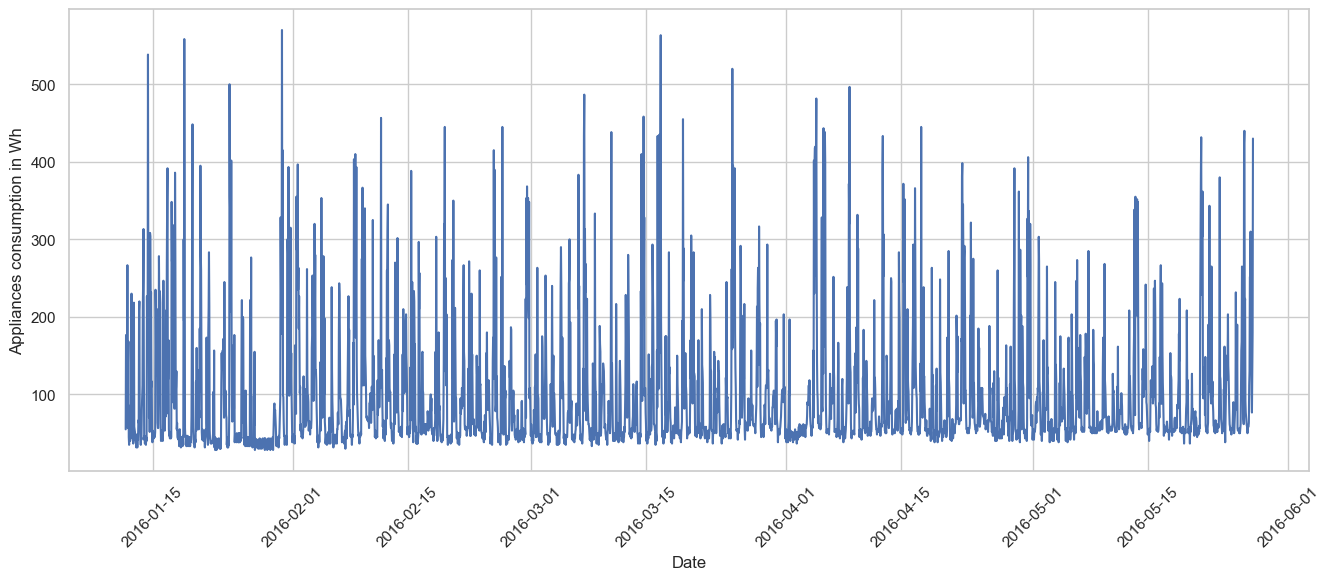

In [37]:
plt.figure(figsize=(16,6))
plt.plot(df_hour.appliances)
plt.xticks( rotation='45')
plt.xlabel('Date')
plt.ylabel('Appliances consumption in Wh')

In [38]:
# Functions to be used from the plots

def daily(x,df=df):
    return df.groupby('weekday')[x].mean()
def hourly(x,df=df):
    return df.groupby('hour')[x].mean()

def monthly_daily(x,df=df):
    by_day = df.pivot_table(index='weekday', 
                                columns=['month'],
                                values=x,
                                aggfunc='mean')
    return round(by_day, ndigits=2)

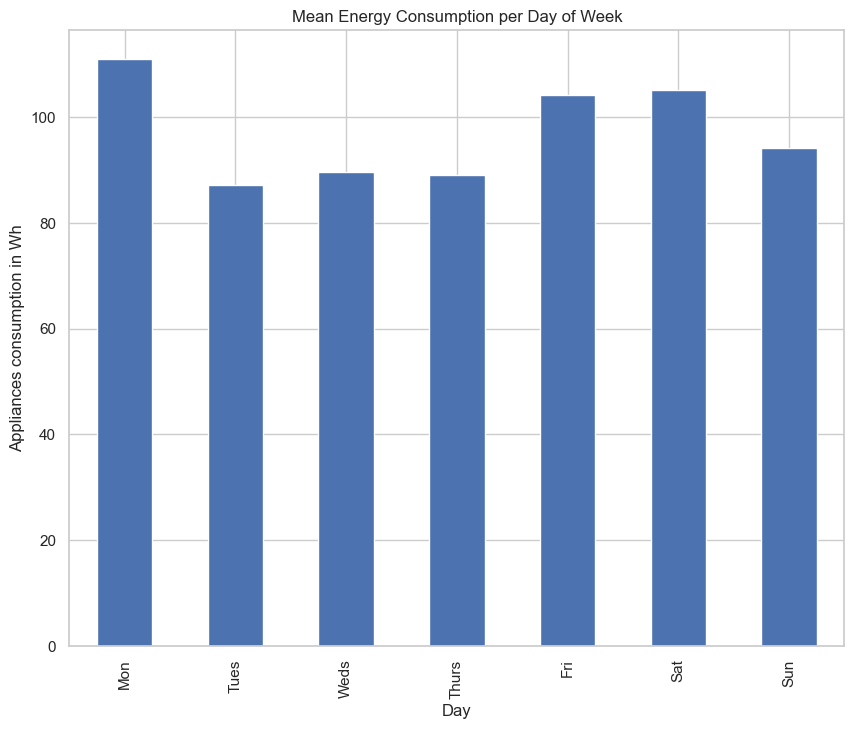

In [39]:
# Plot of Mean Energy Consumption per Day of Week

daily('appliances').plot(kind = 'bar', figsize=(10,8))
ticks = list(range(0, 7, 1)) 
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xlabel('Day')
plt.ylabel('Appliances consumption in Wh')
plt.title('Mean Energy Consumption per Day of Week')
plt.xticks(ticks, labels);

The power load is a bit higher on Monday ,Friday, Saturday and Sunday than the other days.

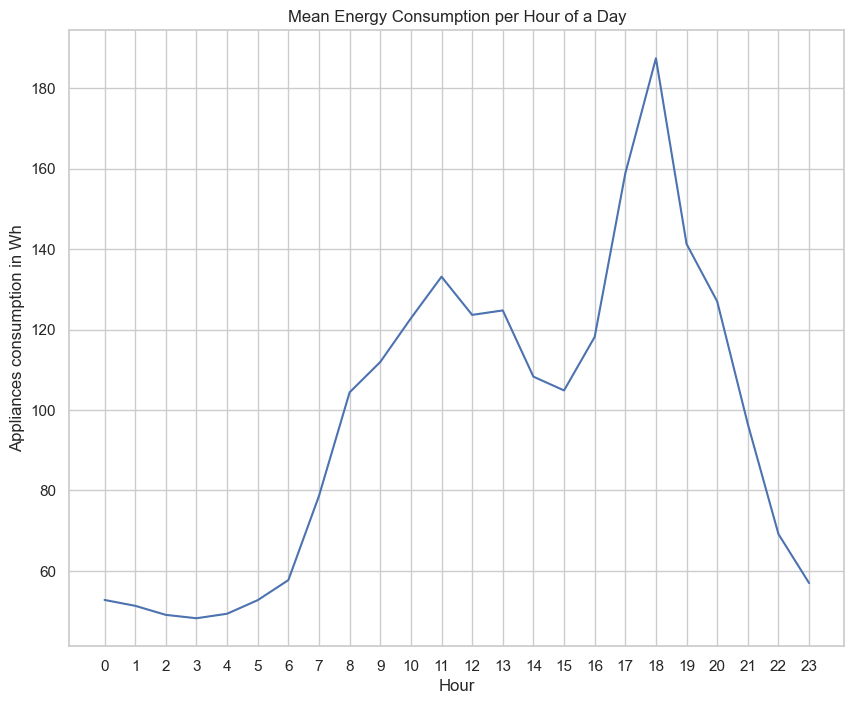

In [40]:
# Plot of Mean Energy Consumption per Hour of a Day

hourly('appliances').plot(figsize=(10,8))
plt.xlabel('Hour')
plt.ylabel('Appliances consumption in Wh')
ticks = list(range(0, 24, 1))
plt.title('Mean Energy Consumption per Hour of a Day')

plt.xticks(ticks);

At night hours from 22:00-7:00 the power load is below 80Wh, meaning that most appliances are off or standby. Between 9:00-13:00 the power load is 120-135Wh and after launch reduces again to 110Wh. At afternoon, the energy consumption ranges from 130-185Wh as family members are at home and many devices are on.

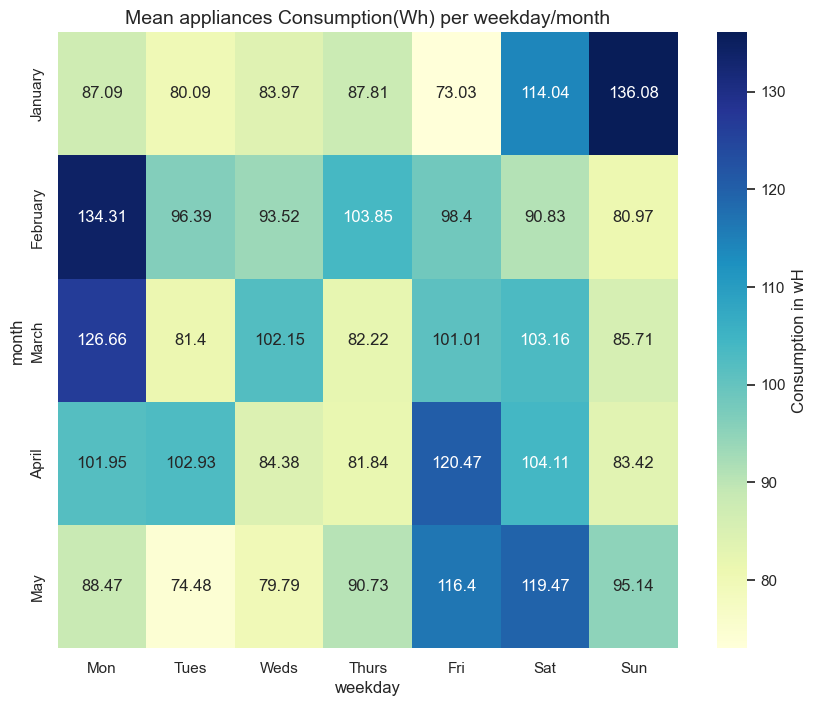

In [41]:
# Heatmap: Mean consumption per Weekday of Month
sns.set(rc={'figure.figsize':(10,8)},)
ax=sns.heatmap(monthly_daily('appliances').T,cmap="YlGnBu",
               xticklabels="Mon Tues Weds Thurs Fri Sat Sun".split(),
               yticklabels="January February March April May".split(),
               annot=True, fmt='g',
               cbar_kws={'label': 'Consumption in wH'}).set_title("Mean appliances Consumption(Wh) per weekday/month").set_fontsize('14')

plt.show()

We can see from the heatmap above that the assumption that more power is consumed on Monday ,Friday, Saturday and Sunday is valid for each month. However, in our data set we have only 4,5 months and threfore we cannot use months as feature for our model.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Appliances log(wH)')

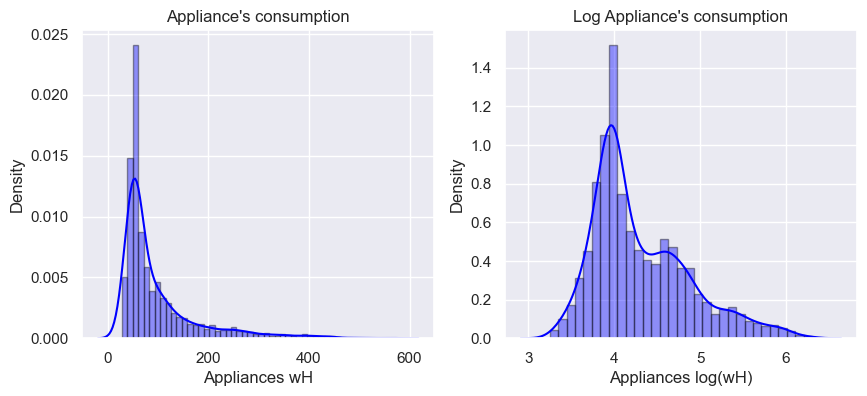

In [42]:
#Histogram of Appliance's consumption

f, axes = plt.subplots(1, 2,figsize=(10,4))

sns.distplot(df_hour.appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[0])
axes[0].set_title("Appliance's consumption")
axes[0].set_xlabel('Appliances wH')

sns.distplot(df_hour.log_appliances, hist=True, color = 'blue',hist_kws={'edgecolor':'black'},ax=axes[1])
axes[1].set_title("Log Appliance's consumption")
axes[1].set_xlabel('Appliances log(wH)')

The distribution of power load is not normal as we have left asymetry, for this reason i wiil use in my analysis log(power load) which distribution is more normal.

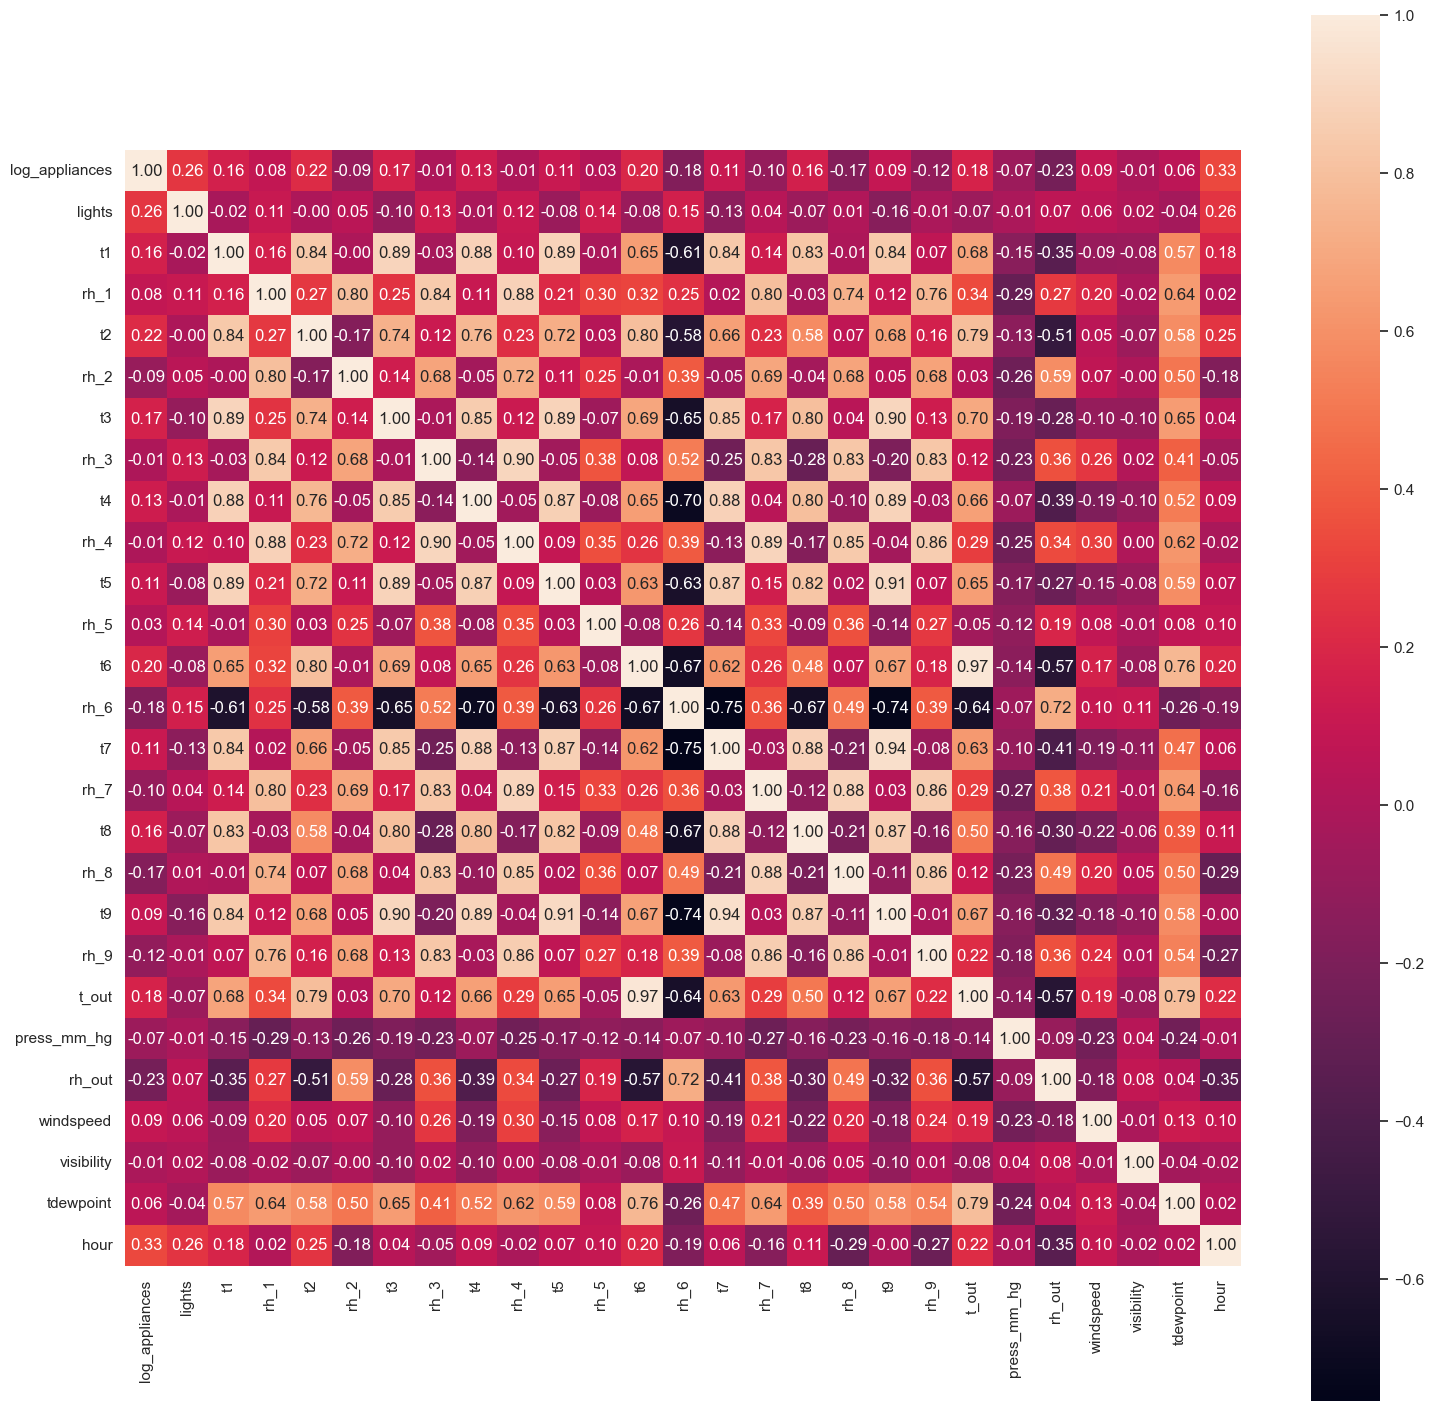

In [43]:
# Pearson Correlation among the variables
col = ['log_appliances', 'lights', 't1', 'rh_1', 't2', 'rh_2', 't3', 'rh_3', 't4',
       'rh_4', 't5', 'rh_5', 't6', 'rh_6', 't7', 'rh_7', 't8', 'rh_8', 't9',
       'rh_9', 't_out', 'press_mm_hg', 'rh_out', 'windspeed', 'visibility',
       'tdewpoint','hour']
corr = df[col].corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

The most correlated features with energy consumtion(log_appliances) are: hour=0.33, lights=0.26, t6=0.20, t2=0.22, t3 = 0.17,t_out = 0.18, rh_out = -0.23, rh_8 = -0.17, rh_6 = -0.18, windspeed = 0.09.

Bellow we examine linear dependence among some basic features of our data set. In a linear regression problem only linear independent variables can be be used as features to explain energy consumption in other way we will have multicolinearity issues.

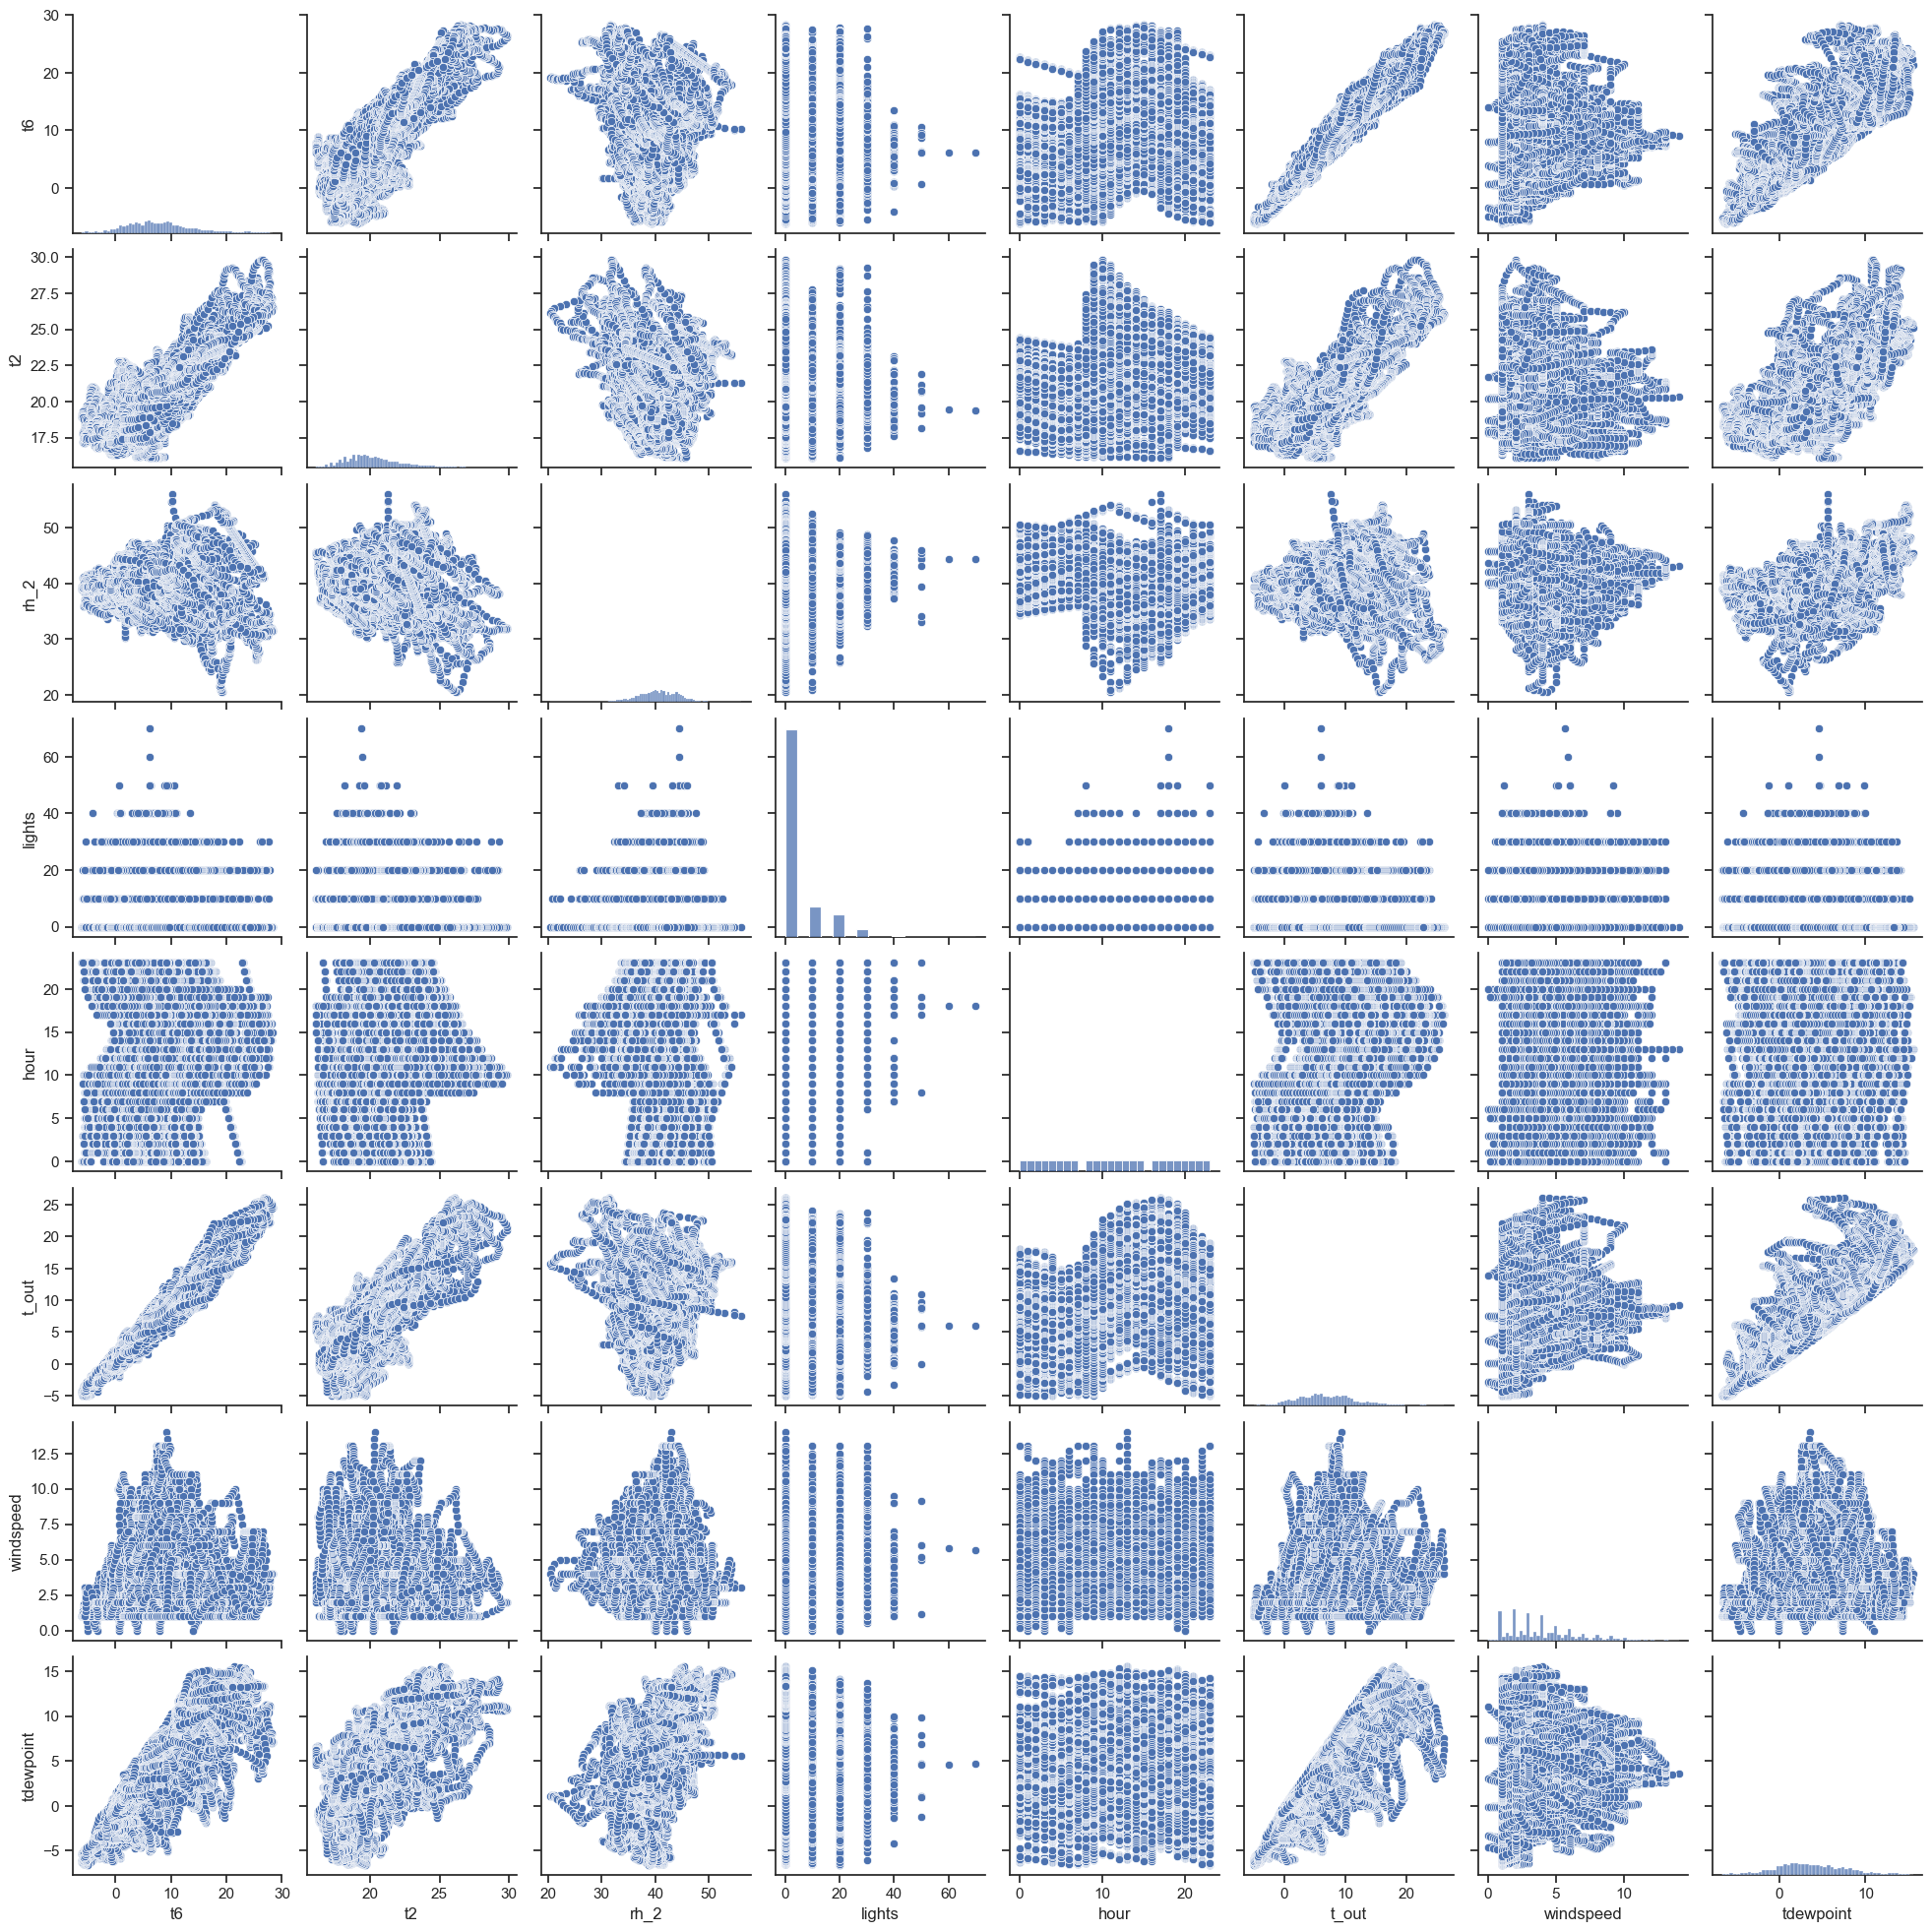

In [44]:
col = ['t6','t2', 'rh_2','lights','hour','t_out','windspeed','tdewpoint']
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[col])
plt.show();

We can see from the plots above that temperatures (in or out) and tdewpoint have linear relationship. For this reason I will use only a temperature in house as feature to the linear model. Addionally, i will choose the temperature and the humidity from the room which have the maximum correlation with the appliances' load.

I ran a random forest model with all the original features to examine the importance of each one to predict appliances' consumption.Bellow are the results, rv1 and rv2 are random variables meaning that variables with less predict power than rv's are useless.
1.feature 29 hour (0.368124)
2.feature 31 low_consum (0.135733)
3.feature 32 high_consum (0.093745)
4.feature 5 t3 (0.030282)
5.feature 9 t5 (0.023667)
6.feature 6 rh_3 (0.022840)
7.feature 15 t8 (0.018802)
8.feature 4 rh_2 (0.018432)
9.feature 7 t4 (0.016923)
10.feature 19 t_out (0.015875)
11.feature 24 tdewpoint (0.015152)
12.feature 10 rh_5 (0.014788)
13.feature 0 lights (0.014463)
14.feature 16 rh_8 (0.013593)
15.feature 2 rh_1 (0.012962)
16.feature 3 t2 (0.012952)
17.feature 13 t7 (0.012847)
18.feature 12 rh_6 (0.012307)
19.feature 20 press_mm_hg (0.012108)
20.feature 8 rh_4 (0.011666)
21.feature 11 t6 (0.011654)
22.feature 14 rh_7 (0.011503)
23.feature 17 t9 (0.011331)
24.feature 21 rh_out (0.011270)
25.feature 23 visibility (0.011161)
26.feature 18 rh_9 (0.010497)
27.feature 1 t1 (0.009998)
28.feature 28 weekday (0.009732)
29.feature 25 rv1 (0.009156)
30.feature 26 rv2 (0.009093)
31.feature 22 windspeed (0.009055)
32.feature 30 week (0.007291)
33.feature 27 month (0.000999)